### Part 1: Imbalanced Dataset

- In this homework, you will be working with an imbalanced Dataset. 
- The dataset is Credit Card Fraud Detection dataset which was hosted on Kaggle. 
- The aim is to detect fraudlent transactions.

### Instructions

1) Please push the .ipynb and .pdf to Github Classroom prior to the deadline, .py file is optional (not needed).<br>
2) Please include your Name and UNI below.

### Name: Xinyu Li
### UNI: XL3228

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [2]:
# Feel free to import any other packages you need

### **Data Preprocessing and Exploration**.
- Download the Kaggle Credit Card Fraud data set.<br>
- Features V1, V2, … V27, V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.<br>
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. <br>
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.<br>
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


### **Examining the class Imbalance**
**1.1 How many observations are in this dataset? How many are positive and negative?** <br>
(Note: Positive labels are labeled as 1)

In [4]:
# Your Code Here
num_observations = raw_df.shape[0]
num_neg_obs = raw_df['Class'].value_counts()[0]
num_pos_obs = raw_df['Class'].value_counts()[1]
print(f"number of observations: {num_observations}")
print(f"number of positive observations: {num_pos_obs}")
print(f"number of negative observations: {num_neg_obs}")

number of observations: 284807
number of positive observations: 492
number of negative observations: 284315


#### **1.2 Cleaning and normalizing the data**
The raw data has a few issues. <br>
Since we are unsure what the time column actually means so drop the Time column. 
The Amount column also has a wide range of values covered so we take the log of the Amount column to reduce its range. <br>

The below is already done for you.

In [5]:
cleaned_df = raw_df.copy()

# You don't want the 'Time' column. Pop it off
cleaned_df.pop('Time')

# The 'Amount' column covers a huge range. Convert it to log-space.
eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount') + eps)

In [6]:
cleaned_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.260067
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,3.210481
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,4.217756
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,2.302685


**1.2.1 Split the dataset into development and test sets. Set test size as 20% and random state as 42. Print the shape of your development and test features**

In [7]:
# Your Code Here
X = cleaned_df.drop('Class', axis=1)
y = cleaned_df['Class']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Shape of development features: {X_dev.shape}")
print(f"Shape of test features: {X_test.shape}")

Shape of development features: (227845, 29)
Shape of test features: (56962, 29)


**1.2.2 Normalize the features using Standard Scaler from Sklearn.**

In [8]:
# Your Code Here
scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(X_dev)
X_test_scaled = scaler.transform(X_test)

### **Default Baseline**
**1.3.1 First, let us fit a default Decision tree classifier (use max_depth=10 and random_state=42). Print the AUC and Average Precision values of 5 Fold Cross Validation**

In [9]:
# Your Code Here
scores = cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), 
                        X_dev_scaled, 
                        y_dev, 
                        cv=5, 
                        scoring = ['roc_auc','average_precision'])
print(f"AUC values of 5 fold cross validation: {scores['test_roc_auc']}")
print(f"Mean AUC Score: {scores['test_roc_auc'].mean()}")
print(f"Average Precision values of 5 fold cross validation: {scores['test_average_precision']}")
print(f"Mean Average Precision: {scores['test_average_precision'].mean()}")

AUC values of 5 fold cross validation: [0.88756328 0.88400873 0.81260522 0.77454358 0.82104149]
Mean AUC Score: 0.8359524571279693
Average Precision values of 5 fold cross validation: [0.62653551 0.71014615 0.60399496 0.58692296 0.68112078]
Mean Average Precision: 0.641744070059615


### **Random Oversampling**
**1.3.2 Perform random oversampling on the development dataset.**

*   How many positive and negative labels do you observe after random oversampling?
*   What is the shape of your development dataset?

(Note: Set random state as 42 when performing oversampling)

In [10]:
# Your Code Here
ros = RandomOverSampler(random_state = 42)
X_dev_oversample, y_dev_oversample = ros.fit_resample(X_dev_scaled, y_dev)
print("----------------------------------------------------------------------------------------------")
print(f"Shape of the feature matrix X of the original development data sets: {X_dev_scaled.shape}")
print(f"Shape of the target variable y of the original development data sets: {y_dev.shape}")
print(f"Shape of the whole original development data sets: {(X_dev_scaled.shape[0], X_dev_scaled.shape[1] + 1)}")
print(f"Amount of negative observations before random oversampling: {y_dev.value_counts()[0]}")
print(f"Amount of positive observations before random oversampling: {y_dev.value_counts()[1]}")
print("----------------------------------------------------------------------------------------------")
print(f"Shape of the feature matrix X of the oversampled development data sets {X_dev_oversample.shape}")
print(f"Shape of the target variable y of the oversampled development data sets {y_dev_oversample.shape}")
print(f"Shape of the whole oversampled development data sets: {(X_dev_oversample.shape[0], X_dev_oversample.shape[1] + 1)}")
print(f"Amount of negative observations after random oversampling: {y_dev_oversample.value_counts()[0]}")
print(f"Amount of positive observations after random oversampling: {y_dev_oversample.value_counts()[1]}")

----------------------------------------------------------------------------------------------
Shape of the feature matrix X of the original development data sets: (227845, 29)
Shape of the target variable y of the original development data sets: (227845,)
Shape of the whole original development data sets: (227845, 30)
Amount of negative observations before random oversampling: 227451
Amount of positive observations before random oversampling: 394
----------------------------------------------------------------------------------------------
Shape of the feature matrix X of the oversampled development data sets (454902, 29)
Shape of the target variable y of the oversampled development data sets (454902,)
Shape of the whole oversampled development data sets: (454902, 30)
Amount of negative observations after random oversampling: 227451
Amount of positive observations after random oversampling: 227451


**1.3.3 Repeat 1.3.1 using the dataset you created in the above step (1.3.2 Random oversampling). <br>(Make sure you use the same hyperparameters as 1.3.1. i.e., max_depth=10, random_state=42 and 5 Fold Cross Validation) <br>
This will help us to compare the models.**

In [11]:
# Your Code Here
scores = cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), 
                        X_dev_oversample, 
                        y_dev_oversample, 
                        cv=5, 
                        scoring = ['roc_auc','average_precision'])
print(f"AUC values of 5 fold cross validation: {scores['test_roc_auc']}")
print(f"Mean AUC Score: {scores['test_roc_auc'].mean()}")
print(f"Average Precision values of 5 fold cross validation: {scores['test_average_precision']}")
print(f"Mean Average Precision: {scores['test_average_precision'].mean()}")

AUC values of 5 fold cross validation: [0.99886808 0.99929956 0.99900977 0.99926441 0.99932258]
Mean AUC Score: 0.9991528810903473
Average Precision values of 5 fold cross validation: [0.99816396 0.99884446 0.99826911 0.9986672  0.99874564]
Mean Average Precision: 0.9985380738652964


### **Random Undersampling**
**1.3.4 Perform Random undersampling on the development dataset.**

- How many positive and negative labels do you observe after random undersampling?
- What is the shape of your development dataset?

(Note: Set random state as 42 when performing undersampling)

In [12]:
# Your Code Here
rus = RandomUnderSampler(replacement=False, random_state = 42)
X_dev_undersample, y_dev_undersample = rus.fit_resample(X_dev_scaled, y_dev)
print("----------------------------------------------------------------------------------------------")
print(f"Shape of the feature matrix X of the original development data sets: {X_dev_scaled.shape}")
print(f"Shape of the target variable y of the original development data sets: {y_dev.shape}")
print(f"Shape of the whole original development data sets: {(X_dev_scaled.shape[0], X_dev_scaled.shape[1] + 1)}")
print(f"Amount of negative observations before random undersampling: {y_dev.value_counts()[0]}")
print(f"Amount of positive observations before random undersampling: {y_dev.value_counts()[1]}")
print("----------------------------------------------------------------------------------------------")
print(f"Shape of the feature matrix X of the undersampled development data sets {X_dev_undersample.shape}")
print(f"Shape of the target variable y of the undersampled development data sets {y_dev_undersample.shape}")
print(f"Shape of the whole undersampled development data sets{(X_dev_undersample.shape[0], X_dev_undersample.shape[1] + 1)}")
print(f"Amount of negative observations after random oversampling: {y_dev_undersample.value_counts()[0]}")
print(f"Amount of positive observations after random oversampling: {y_dev_undersample.value_counts()[1]}")

----------------------------------------------------------------------------------------------
Shape of the feature matrix X of the original development data sets: (227845, 29)
Shape of the target variable y of the original development data sets: (227845,)
Shape of the whole original development data sets: (227845, 30)
Amount of negative observations before random undersampling: 227451
Amount of positive observations before random undersampling: 394
----------------------------------------------------------------------------------------------
Shape of the feature matrix X of the undersampled development data sets (788, 29)
Shape of the target variable y of the undersampled development data sets (788,)
Shape of the whole undersampled development data sets(788, 30)
Amount of negative observations after random oversampling: 394
Amount of positive observations after random oversampling: 394


**1.3.5 Repeat 1.3.1 using the dataset you created in the above step(1.3.4 Random undersampling).<br>(Make sure you use the same hyperparameters as 1.3.1. i.e., max_depth=10, random_state=42 and 5 Fold Cross Validation)<br>
This will help us to compare the models**

In [13]:
# Your Code Here
scores = cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), 
                        X_dev_undersample, 
                        y_dev_undersample, 
                        cv=5, 
                        scoring = ['roc_auc','average_precision'])
print(f"AUC values of 5 fold cross validation: {scores['test_roc_auc']}")
print(f"Mean AUC Score: {scores['test_roc_auc'].mean()}")
print(f"Average Precision values of 5 fold cross validation: {scores['test_average_precision']}")
print(f"Mean Average Precision: {scores['test_average_precision'].mean()}")

AUC values of 5 fold cross validation: [0.93662875 0.94936709 0.9097901  0.92583577 0.92989289]
Mean AUC Score: 0.9303029182535673
Average Precision values of 5 fold cross validation: [0.91336577 0.92661432 0.86678359 0.90629539 0.89830283]
Mean Average Precision: 0.9022723811037444


### **SMOTE**
**1.3.6 Perform Synthetic Minority Oversampling Technique (SMOTE) on the development dataset**

- How many positive and negative labels do you observe after performing SMOTE?
- What is the shape of your development dataset?

(Note: Set random state as 42 when performing SMOTE)

In [14]:
# Your Code Here
smote = SMOTE(random_state=42)
X_dev_smote, y_dev_smote = smote.fit_resample(X_dev_scaled, y_dev)
print("----------------------------------------------------------------------------------------------")
print(f"Shape of the feature matrix X of the original development data sets: {X_dev_scaled.shape}")
print(f"Shape of the target variable y of the original development data sets: {y_dev.shape}")
print(f"Shape of the whole original development data sets: {(X_dev_scaled.shape[0], X_dev_scaled.shape[1] + 1)}")
print(f"Amount of negative observations before SMOTE: {y_dev.value_counts()[0]}")
print(f"Amount of positive observations before SMOTE: {y_dev.value_counts()[1]}")
print("----------------------------------------------------------------------------------------------")
print(f"Shape of the feature matrix X of the SMOTE development data sets {X_dev_smote.shape}")
print(f"Shape of the target variable y of the SMOTE development data sets {y_dev_smote.shape}")
print(f"Shape of the whole SMOTE development data sets{(X_dev_smote.shape[0], X_dev_smote.shape[1] + 1)}")
print(f"Amount of negative observations after SMOTE: {y_dev_smote.value_counts()[0]}")
print(f"Amount of positive observations after SMOTE: {y_dev_smote.value_counts()[1]}")

----------------------------------------------------------------------------------------------
Shape of the feature matrix X of the original development data sets: (227845, 29)
Shape of the target variable y of the original development data sets: (227845,)
Shape of the whole original development data sets: (227845, 30)
Amount of negative observations before SMOTE: 227451
Amount of positive observations before SMOTE: 394
----------------------------------------------------------------------------------------------
Shape of the feature matrix X of the SMOTE development data sets (454902, 29)
Shape of the target variable y of the SMOTE development data sets (454902,)
Shape of the whole SMOTE development data sets(454902, 30)
Amount of negative observations after SMOTE: 227451
Amount of positive observations after SMOTE: 227451


**1.3.7 Repeat 1.3.1 using the dataset you created in the above step(1.3.4 SMOTE).<br>(Make sure you use the same hyperparameters as 1.3.1. i.e., max_depth=10, random_state=42 and 5 Fold Cross Validation)<br>
This will help us to compare the models**

In [15]:
# Your Code Here
scores = cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), 
                        X_dev_smote, 
                        y_dev_smote, 
                        cv=5, 
                        scoring = ['roc_auc','average_precision'])
print(f"AUC values of 5 fold cross validation: {scores['test_roc_auc']}")
print(f"Mean AUC Score: {scores['test_roc_auc'].mean()}")
print(f"Average Precision values of 5 fold cross validation: {scores['test_average_precision']}")
print(f"Mean Average Precision: {scores['test_average_precision'].mean()}")

AUC values of 5 fold cross validation: [0.99757923 0.99738426 0.99772842 0.9972463  0.99714931]
Mean AUC Score: 0.9974175030591891
Average Precision values of 5 fold cross validation: [0.99667622 0.99645425 0.99685462 0.99619248 0.99611009]
Mean Average Precision: 0.9964575330041552


### **Balanced Weight**

**1.3.8 Train a balanced default Decision tree classifier. <br> [ use max_depth=10 and random_state=42 and balance the class weights with 5 Fold Cross Validation ] <br>
Print the AUC and average precision on dev set**

In [16]:
# Your Code Here
scores = cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced'), 
                        X_dev_scaled, 
                        y_dev, 
                        cv=5, 
                        scoring = ['roc_auc','average_precision'])
print(f"AUC values of 5 fold cross validation: {scores['test_roc_auc']}")
print(f"Mean AUC Score: {scores['test_roc_auc'].mean()}")
print(f"Average Precision values of 5 fold cross validation: {scores['test_average_precision']}")
print(f"Mean Average Precision: {scores['test_average_precision'].mean()}")

AUC values of 5 fold cross validation: [0.88026358 0.95432645 0.90415573 0.91647782 0.87235086]
Mean AUC Score: 0.905514887383234
Average Precision values of 5 fold cross validation: [0.51935587 0.573068   0.50745277 0.56269097 0.4556111 ]
Mean Average Precision: 0.5236357414975382


### **Model Prediction & Evaluation**
**1.4.1 Make predictions on the test set using the five models that you built and report their AUC values.**<br>
(Five models include models from - Default Baseline, Random Undersampling, Random Oversampling, SMOTE & Balanced Weight)

In [17]:
# Your Code Here

#initialize models
baseline = DecisionTreeClassifier(max_depth=10, random_state=42)
rus_pipe = imb_make_pipeline(rus, DecisionTreeClassifier(max_depth=10, random_state=42))
ros_pipe = imb_make_pipeline(ros, DecisionTreeClassifier(max_depth=10, random_state=42))
smote_pipe = imb_make_pipeline(smote,DecisionTreeClassifier(max_depth=10, random_state=42))
balanced_weight = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')

#fit models using development set
baseline.fit(X_dev_scaled, y_dev)
rus_pipe.fit(X_dev_scaled, y_dev)
ros_pipe.fit(X_dev_scaled, y_dev)
smote_pipe.fit(X_dev_scaled, y_dev)
balanced_weight.fit(X_dev_scaled, y_dev)

#make predictions
y_pred_baseline = baseline.predict(X_test_scaled)
y_pred_rus = rus_pipe.predict(X_test_scaled)
y_pred_ros = ros_pipe.predict(X_test_scaled)
y_pred_smote = smote_pipe.predict(X_test_scaled)
y_pred_balanced_weight = balanced_weight.predict(X_test_scaled)

#make probability predictions
y_pred_prob_baseline = baseline.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_rus = rus_pipe.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_ros = ros_pipe.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_smote = smote_pipe.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_balanced_weight = balanced_weight.predict_proba(X_test_scaled)[:, 1]


#calculating scores
auc_baseline = roc_auc_score(y_test, y_pred_prob_baseline)
auc_rus = roc_auc_score(y_test, y_pred_prob_rus)
auc_ros = roc_auc_score(y_test, y_pred_prob_ros)
auc_smote = roc_auc_score(y_test, y_pred_prob_smote)
auc_balanced_weight = roc_auc_score(y_test, y_pred_prob_balanced_weight)

#Report the scores
print(f"AUC value over test set using the baseline model: {auc_baseline}")
print(f"AUC value over test set using the random undersampling: {auc_rus}")
print(f"AUC value over test set using the random oversampling: {auc_ros}")
print(f"AUC value over test set using the SMOTE: {auc_smote}")
print(f"AUC value over test set using the balanced weight: {auc_balanced_weight}")

AUC value over test set using the baseline model: 0.8196316775866227
AUC value over test set using the random undersampling: 0.8959979162599198
AUC value over test set using the random oversampling: 0.9016732009348478
AUC value over test set using the SMOTE: 0.8752678248423735
AUC value over test set using the balanced weight: 0.9017402244381152


**1.4.2 Plot Confusion Matrices for all the five models on the test set. Comment your results and share your observations of the confusion matrices in detail (Explanation carries lot of points)**<br>
(Five models include models from - Default Baseline, Random Undersampling, Random Oversampling, SMOTE & Balanced Weight)

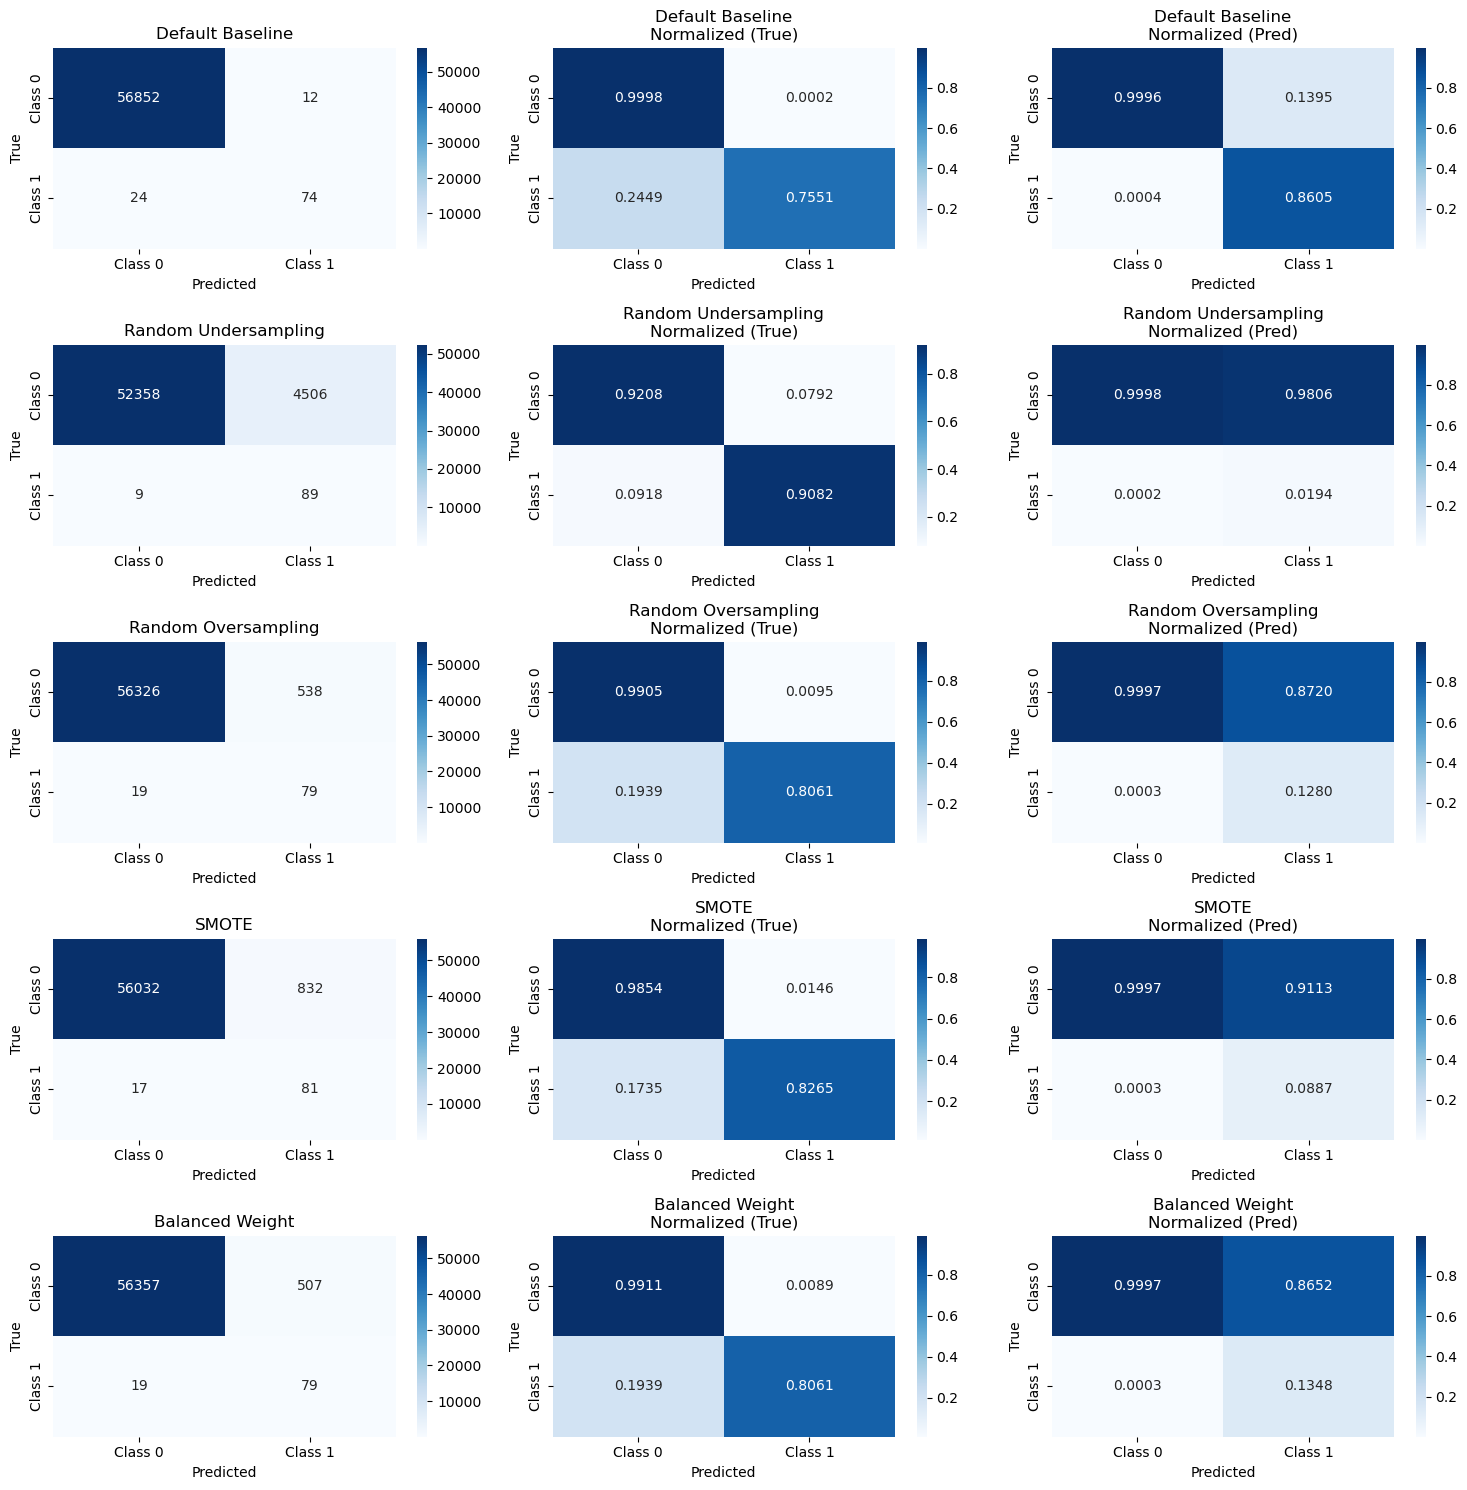

In [18]:
models = ['Default Baseline', 'Random Undersampling', 'Random Oversampling', 'SMOTE', 'Balanced Weight']
confusion_matrices = [confusion_matrix(y_test, y_pred_baseline), 
                      confusion_matrix(y_test, y_pred_rus), 
                      confusion_matrix(y_test, y_pred_ros), 
                      confusion_matrix(y_test, y_pred_smote), 
                      confusion_matrix(y_test, y_pred_balanced_weight)]
confusion_matrices_true = [confusion_matrix(y_test, y_pred_baseline, normalize='true'), 
                      confusion_matrix(y_test, y_pred_rus, normalize='true'), 
                      confusion_matrix(y_test, y_pred_ros, normalize='true'), 
                      confusion_matrix(y_test, y_pred_smote, normalize='true'), 
                      confusion_matrix(y_test, y_pred_balanced_weight, normalize='true')]
confusion_matrices_pred = [confusion_matrix(y_test, y_pred_baseline, normalize='pred'), 
                      confusion_matrix(y_test, y_pred_rus, normalize='pred'), 
                      confusion_matrix(y_test, y_pred_ros, normalize='pred'), 
                      confusion_matrix(y_test, y_pred_smote, normalize='pred'), 
                      confusion_matrix(y_test, y_pred_balanced_weight, normalize='pred')]
class_labels = ['Class 0', 'Class 1']
normalize_options = [None, 'true', 'pred']
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
for i in range(5):
    for j, normalize_option in enumerate(normalize_options):
        ax = axes[i, j]
        cm = confusion_matrices[i]
        if normalize_option == 'true':
            cm = confusion_matrices_true[i]                
        elif normalize_option == 'pred':
            cm = confusion_matrices_pred[i]
        sns.heatmap(cm, annot=True, fmt='.4f' if normalize_option else 'd', cmap='Blues', 
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax)
        ax.set_title(models[i] + ('\nNormalized (True)' if normalize_option == 'true' 
                                  else ('\nNormalized (Pred)' if normalize_option == 'pred' else '')))
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
plt.tight_layout()
plt.show()

- By examining non-normalized confusion matrix (1st Column)
    - Default baseline model performs best in terms of making the most amount of True Negative Predictions (56852).
    - Default baseline model performs best in terms of making the least amount of False Postive Predictions (12).
    - Random undersampling model performs best in terms of making the least amount of False Negative Predictions (24).
    - Random undersampling model performs best in terms of making the most amount of True Postive Predictions (89).
- By examining noramlized confusion matrix by adding the parameter (normalize='true') (2nd Column)
    - Default baseline model performs best in terms of the highest true negative rate (specificity) of 0.9998.
    - Default baseline model performs best in terms of the lowest false positive rate (fall-out) of 0.0002.
    - Random undersampling model performs best in terms of the lowest false negative rate (miss-rate) of 0.0918.
    - Random undersampling model performs best in terms of the highest true positive rate (recall/sensitivity) of 0.9082.
- By examining normalized confusion matrix by adding the parameter (normalize='Pred') (3rd Column)
    - Random undersampling model performs best in terms of the highest negative predictive value of 0.9998.
    - Default baseline model performs best in terms of the lowest false discovery rate of 0.1395.
    - Random undersampling model performs best in terms of the lowest false omission rate of 0.0002.
    - Default baseline model performs best in terms of the highest positive predictive value (precision) of 0.8605.
- In case of credit card fraud prediction
    - When the frequency of fraudulent transactions is generally insignificant, and our top priority is customer satisfaction, the cost of false positives, which involves identifying innocent customers as fraudsters, is exceptionally high. In such cases, our primary focus is to maximize precision, default baseline model is the best (precision of 0.8605).
    - Conversely, when the monetary value of fraudulent transactions is typically substantial, the cost of false negatives, which involves failing to identify actual fraud transactions, becomes notably high. In these situations, our key objective is to maximize recall, random unndesampling model is the best (recall of 0.9082).

**1.4.3 Plot ROC for all the five models on the test set in a single plot. Make sure you label axes and legend properly. Comment on your results and share your observations in detail (Explanation carries lot of points)**<br>
(Five models include models from - Default Baseline, Random Undersampling, Random Oversampling, SMOTE & Balanced Weight)

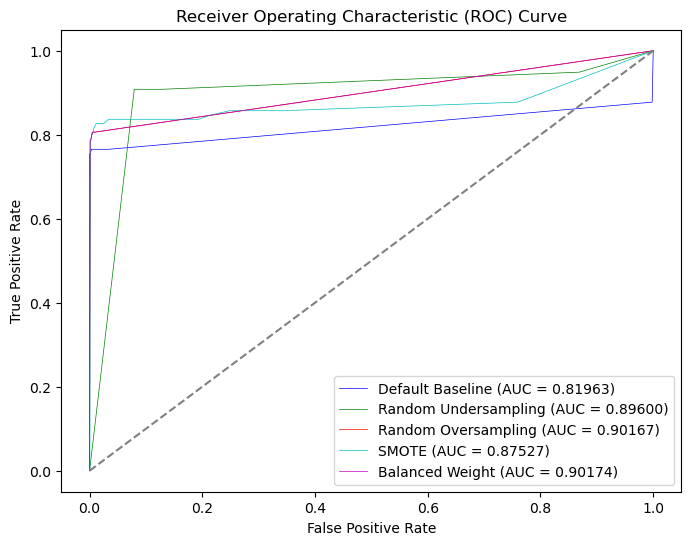

In [19]:
# Compute ROC curves and AUC for different models
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_prob_baseline, pos_label=1)
fpr_rus, tpr_rus, _ = roc_curve(y_test, y_pred_prob_rus, pos_label=1)
fpr_ros, tpr_ros, _ = roc_curve(y_test, y_pred_prob_ros, pos_label=1)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_prob_smote, pos_label=1)
fpr_balanced_weight, tpr_balanced_weight, _ = roc_curve(y_test, y_pred_prob_balanced_weight, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, color='b', lw=0.5, label=f'Default Baseline (AUC = {auc_baseline:.5f})')
plt.plot(fpr_rus, tpr_rus, color='g', lw=0.5, label=f'Random Undersampling (AUC = {auc_rus:.5f})')
plt.plot(fpr_ros, tpr_ros, color='r', lw=0.5, label=f'Random Oversampling (AUC = {auc_ros:.5f})')
plt.plot(fpr_smote, tpr_smote, color='c', lw=0.5, label=f'SMOTE (AUC = {auc_smote:.5f})')
plt.plot(fpr_balanced_weight, tpr_balanced_weight, color='m', lw=0.5, 
         label=f'Balanced Weight (AUC = {auc_balanced_weight:.5f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

- All Models is better than random guessing (AUC-ROC score greater than 50%)
    - Default Baseline has AUC-ROC of 0.81963.
    - Random Undersampling has AUC-ROC of 0.89600.
    - Random Oversampling has AUC-ROC of 0.90167.
    - SMOTE has AUC-ROC of 0.87527.
    - Balanced Weight has AUC-ROC of 0.90174.
- Balanced Weight performs best in terms of AUC-ROC (0.90174). It means that the model, on average, correctly ranks or orders the instances such that it ranks fraud cases higher than negative non-fraud cases based on P(y=1) approximately 90.174% of the time. 
- Default Baseline performs worst in terms of AUC-ROC (0.81963). It means that the model, on average, correctly ranks or orders the instances such that it ranks fraud cases higher than negative non-fraud cases based on P(y=1) approximately 81.963% of the time.